In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from __future__ import division, print_function
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import h5py
import sympy as sm
import copy
from sympy.abc import *
sm.init_printing()
import fftrefm
reload(fftrefm)
from fftrefm import DDHOZ, DDHOZi, vary_dict, LDS
from scipy import integrate, signal
from scipy.optimize import curve_fit
import tqdm
import sigutils
from kpfm.util import align_labels

def lighter(hex_color, chg):
    rgb = mpl.colors.hex2color(hex_color)
    rgb_out = tuple(min(max(x + chg, 0), 1) for x in rgb)
    return mpl.colors.rgb2hex(rgb_out)

In [2]:
params_full = dict(omega_0=2*np.pi*0.065,
             k=3.5,
             Q=26000.0,
             C=1e-3,
             C2q=0.65e-4,
             C2D=0.65e-4,
             Rs=200,
             Cs=1e-3,
             Vt=lambda t: 0)

T0 = (1/params_full['omega_0']) / (2*np.pi)
dt = T0/4
T = 20000
N = int(T/dt)
t = np.arange(N) * dt

params_full['Ci'] = 0.001
params_full['Ri'] = 300

fam = 160e-6

sim_params=dict(A=0.05, t=t)

ddhozi = DDHOZi(**params_full)

# # y0zi = np.array([0.00, 0, -1e-3*5, ])

In [3]:
Ris = np.array([60, 300, 300*5, 300*25])
bas = [fftrefm.tf2rc(**params) for params in vary_dict(params_full, 'Ri', Ris)]

In [4]:
zs = np.array([np.polyval(ba[0], (2*np.pi*0.065j)) / np.polyval(ba[1], (2*np.pi*0.065j)) for ba in bas])

In [5]:
params_full['omega_0']/(2*np.pi) * 1e6 / (4*params_full['k']) * (params_full['C2q'] + params_full['C2D']*zs.real)

array([ 0.59690315,  0.5796157 ,  0.51930441,  0.50281642])

In [8]:
import json_tricks

d = json_tricks.load('Fig14-blds-simulation.json')

In [9]:
globals().update(d)

In [10]:
def blds_value(ba, fc, fm, C2q, C2D, Vm=1, k0=3.5):
    H = lambda f: np.polyval(ba[0], 2j*np.pi*f) / np.polyval(ba[1], 2j*np.pi*f)

    Hbar = (H(fm + fc) + H(fm-fc))/2
    return -fc * Vm**2 / (16 * k0) * (C2q + C2D * Hbar.real) * abs(H(fm))**2 * 1e6 # MHz to Hz

In [11]:
print(d['readme'])


Readme
This file contains data for plots showing the results of simulating
the broadband local dielectric spectroscopy experiment.
We see good agreement with the impedance spectoscopy model.

The blds simulations were performed using the command:

    tot = 25
    pbar = tqdm.tqdm_notebook(total=tot*len(Ris))
    lds_s = [BLDS(3e-3, 2, tot, 5, fam, params, sim_params, pbar)
                for params in vary_dict(params_full, 'Ri', Ris)]

The modulation voltage was 5 volts (4th argument of LDS command) and
the amplitude modulation frequency was 160 Hz = 160e-6 MHz.




In [12]:
dparams = d['params_full'] # ease of typing
dparams

OrderedDict([(u'C', 0.001),
 (u'C2q', 6.5e-05),
 (u'Rs', 200),
 (u'k', 3.5),
 (u'omega_0', 0.4084070449666731),
 (u'Ci', 0.001),
 (u'Q', 26000.0),
 (u'C2D', 6.5e-05),
 (u'Cs', 0.001),
 (u'Ri', 300)])

In [13]:
freqs = d['freqs'][0]
delta_fwam = blds_value(ba, dparams['omega_0']/(2*np.pi),
                                         freqs, dparams['C2q'], dparams['C2D'],
                                         Vm=5, k0=dparams['k'])

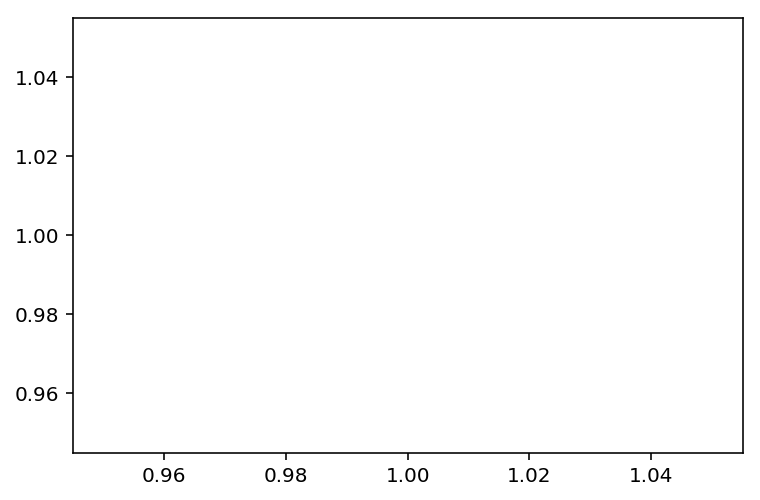

In [14]:
colors = [plt.plot(1, 1)[0].get_color() for i in xrange(4)]

In [15]:
colors_darker = ['#004481', '#CC4C00', '#006D00', '#A30000']
colors_lighter = ['#3991CE', '#FF9928', '#46BA46', '#F04142']

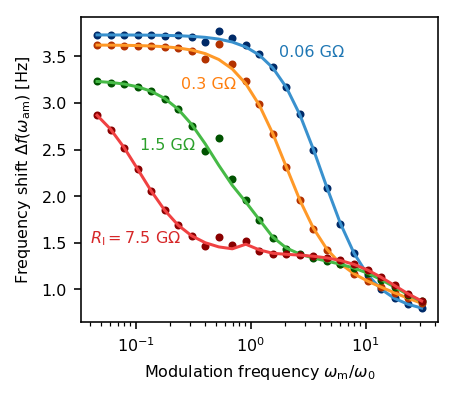

In [16]:
fc = 0.065
plt.rc('font', size=8)
fig, ax = plt.subplots(figsize=(3.2, 2.8))
for i, (freq,  z, sim_freq, Ri, ba) in enumerate(zip(d['freqs'], d['zs'], sim_freqs, d['Ris'], bas)):
    line, = ax.semilogx(freq/fc, -z.real, '.', label=u"$10^{}$ GΩ".format(
            int(np.round(np.log10(Ri)))-3), color=lighter(colors_darker[i], -0.1))
    ax.semilogx(freq/fc, -blds_value(ba, dparams['omega_0']/(2*np.pi),
                                         freq, dparams['C2q'], dparams['C2D'],
                                         Vm=5, k0=dparams['k']).real,
                        color=colors_lighter[i], linestyle='-')

# plt.legend(loc='upper right')
ax.set_xlabel("Modulation frequency $\\omega_\\mathrm{m}/\\omega_0$")
ax.set_ylabel("Frequency shift $\\Delta f(\\omega_\\mathrm{am})$ [Hz]")
ax.text(1.75, 3.5, u'0.06 GΩ', color=colors[0])
ax.text(0.25, 3.15, u'0.3 GΩ', color=colors[1])
ax.text(0.11, 2.5, u'1.5 GΩ', color=colors[2])
ax.text(0.04, 1.5, u'$R_{\mathrm{I}} = $7.5 GΩ', color=colors[3])

In [17]:
fig.savefig('Fig14-blds.pdf', bbox_inches='tight')

